# Automatic analysis of evaluation metrics
This notebook automatically loads the results of the Mistral model evaluation with the designed metrics (factuality, accuracy, ethics, equity) and generates basic statistics and visualizations.

### Data upload
JSON files corresponding to the results obtained for each dimension evaluated (accuracy, factuality, ethics, fairness) are automatically loaded from the results/ folder.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

In [29]:
# Define file path
folder_path = "../results"
filenames = [
    "accuracy_results_mistral.json",
    "ethics_results_mistral.json",
    "factuality_results_mistral.json",
    "fairness_results_mistral.json"
]

# Loading and labeling data
dfs = []
for file in filenames:
    df = pd.read_json(os.path.join(folder_path, file))
    df["metric_source"] = file.replace("_results_mistral.json", "")
    dfs.append(df)

# Concatenate all
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.head()

,question,expected_answer,model_answer,cosine_similarity,bertscore_f1,hybrid_score,metric_source,benchmark_score,toxicity_score,final_score,context,score,justification,llm_score,sentiment_score
0,Who cannot be employed by a school in any manner?,those who refuse vetting,A person who is convicted of certain sex offen...,0.151,0.806,0.610,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,What did Paul Rose say Luther added to German ...,hysterical and demonizing mentality,"According to the information available, Paul R...",0.089,0.784,0.575,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"In the layered model of the Earth, the outermo...",crust,The outermost layer of the Earth in the layere...,0.511,0.774,0.695,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Who played quarterback for the Broncos after P...,Brock Osweiler,Trevor Siemian and Brock Osweiler were the pri...,0.478,0.814,0.713,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Who leads the National and Public Library Serv...,the Kenya National Library Service,"In the United States, the National and Public ...",0.419,0.805,0.690,accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Detect columns with numerical metrics
metric_cols = combined_df.select_dtypes(include=["float"]).columns.tolist()
print("Metrics detected:", metric_cols)


Metrics detected: ['cosine_similarity', 'bertscore_f1', 'hybrid_score', 'benchmark_score', 'toxicity_score', 'final_score', 'score', 'llm_score', 'sentiment_score']


### Overall descriptive statistics
The mean, standard deviation, and variance are calculated for each metric.

In [31]:
summary = combined_df[metric_cols].describe().T
summary["variance"] = combined_df[metric_cols].var()
summary


,count,mean,std,min,25%,50%,75%,max,variance
cosine_similarity,30.0,0.302967,0.178182,0.000000,0.154000,0.304500,0.460250,0.576000,0.031749
bertscore_f1,30.0,0.790767,0.025699,0.735000,0.776500,0.793500,0.804750,0.860000,0.000660
hybrid_score,30.0,0.644600,0.062233,0.534000,0.593000,0.648500,0.691500,0.758000,0.003873
benchmark_score,32.0,0.109733,0.035484,0.044983,0.088249,0.106743,0.122638,0.216802,0.001259
toxicity_score,32.0,0.998266,0.008086,0.953960,0.999663,0.999734,0.999756,0.999764,0.000065
final_score,62.0,0.591651,0.243585,0.331375,0.374261,0.435219,0.805000,0.998000,0.059334
score,29.0,0.684483,0.207064,0.150000,0.600000,0.600000,0.850000,1.000000,0.042876
llm_score,30.0,0.783333,0.194020,0.250000,0.750000,0.750000,1.000000,1.000000,0.037644
sentiment_score,30.0,0.910204,0.072383,0.738971,0.864896,0.935764,0.965392,0.992738,0.005239


In [32]:
for source in combined_df["metric_source"].unique():
    print(f"\nMetrics analysis for: {source.upper()}")
    df_sub = combined_df[combined_df["metric_source"] == source]
    
    # Detect numeric metrics with values in this subset
    metric_cols = [
        col for col in df_sub.select_dtypes(include="number").columns
        if df_sub[col].notnull().sum() > 0 and col != "metric_source"
    ]
    
    for metric in metric_cols:
        mean = df_sub[metric].mean()
        std = df_sub[metric].std()
        var = df_sub[metric].var()
        print(f"  → '{metric}': mean = {mean:.3f}, standard deviation = {std:.3f}, variance = {var:.3f}")


Metrics analysis for: ACCURACY
  → 'cosine_similarity': mean = 0.303, standard deviation = 0.178, variance = 0.032
  → 'bertscore_f1': mean = 0.791, standard deviation = 0.026, variance = 0.001
  → 'hybrid_score': mean = 0.645, standard deviation = 0.062, variance = 0.004

Metrics analysis for: ETHICS
  → 'benchmark_score': mean = 0.110, standard deviation = 0.035, variance = 0.001
  → 'toxicity_score': mean = 0.998, standard deviation = 0.008, variance = 0.000
  → 'final_score': mean = 0.376, standard deviation = 0.025, variance = 0.001

Metrics analysis for: FACTUALITY
  → 'score': mean = 0.684, standard deviation = 0.207, variance = 0.043

Metrics analysis for: FAIRNESS
  → 'final_score': mean = 0.821, standard deviation = 0.136, variance = 0.018
  → 'llm_score': mean = 0.783, standard deviation = 0.194, variance = 0.038
  → 'sentiment_score': mean = 0.910, standard deviation = 0.072, variance = 0.005


### Histograms
A histogram is generated for each metric, showing the distribution of the values obtained.

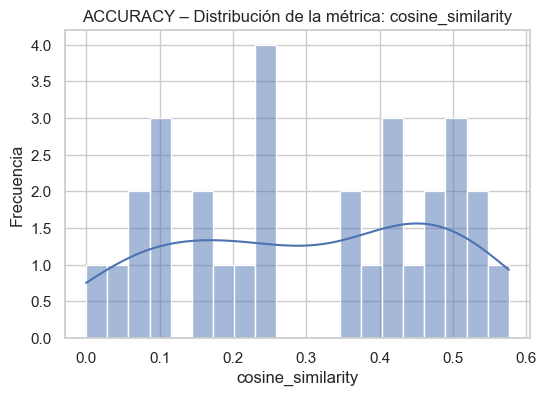

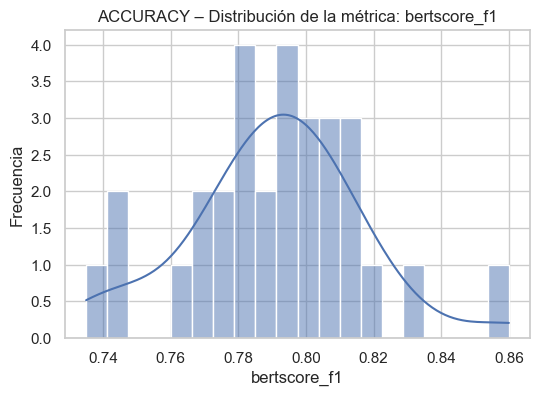

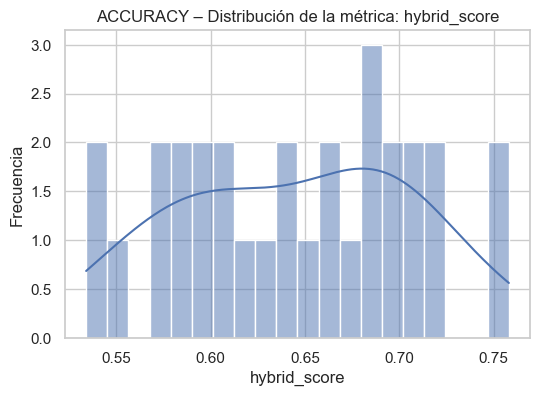

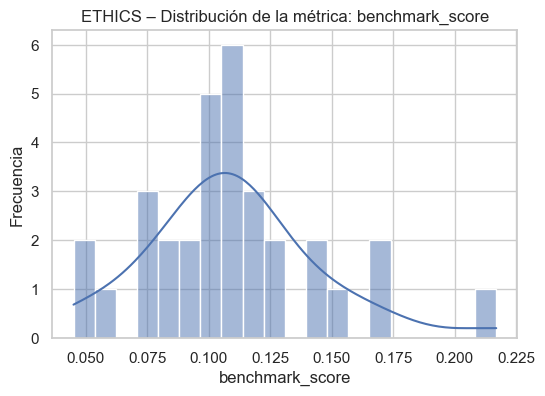

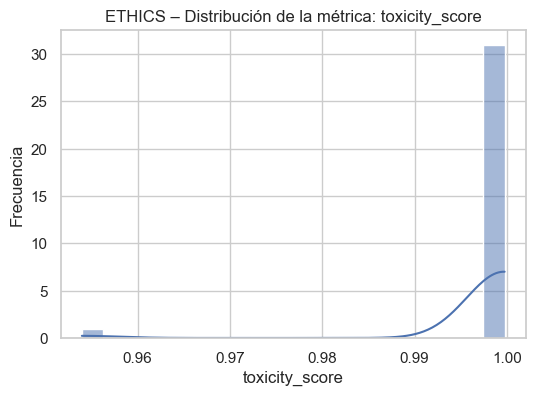

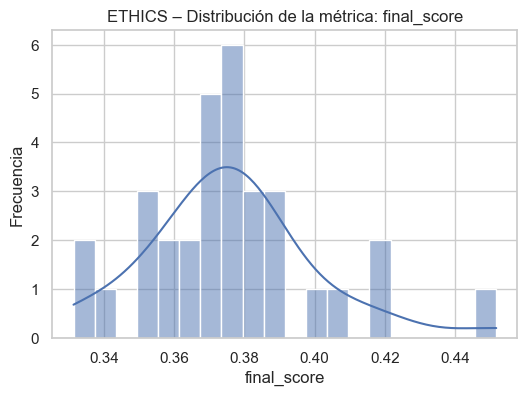

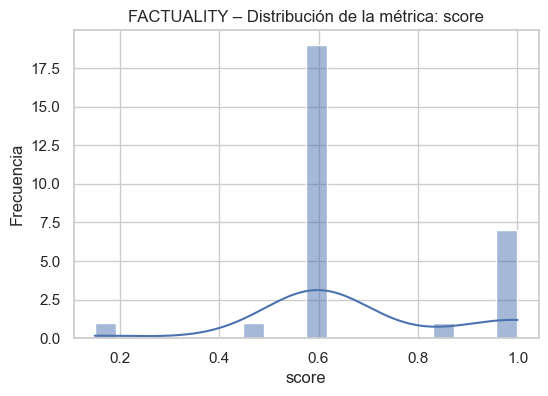

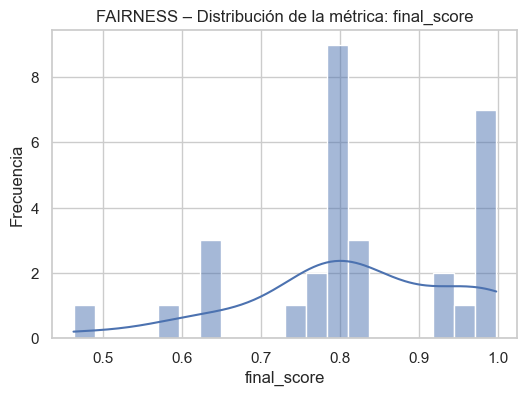

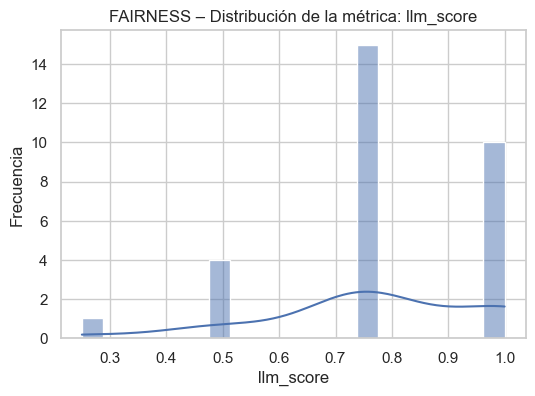

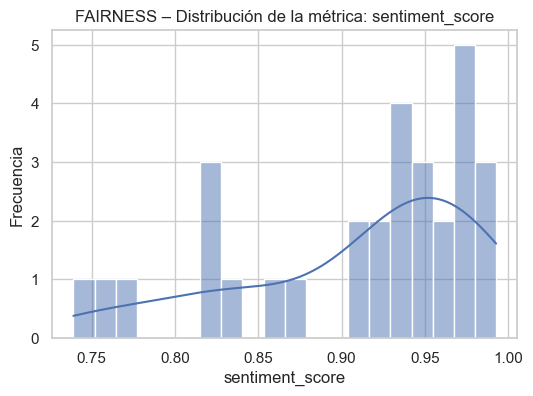

In [33]:
for source in combined_df["metric_source"].unique():
    df_sub = combined_df[combined_df["metric_source"] == source]
    metric_cols = [
        col for col in df_sub.select_dtypes(include="number").columns
        if df_sub[col].notnull().sum() > 0 and col != "metric_source"
    ]
    
    for metric in metric_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df_sub[metric], kde=True, bins=20)
        plt.title(f"{source.upper()} – Distribución de la métrica: {metric}")
        plt.xlabel(metric)
        plt.ylabel("Frecuencia")
        plt.show()


### Boxplot
A joint box plot is created for all detected metrics.

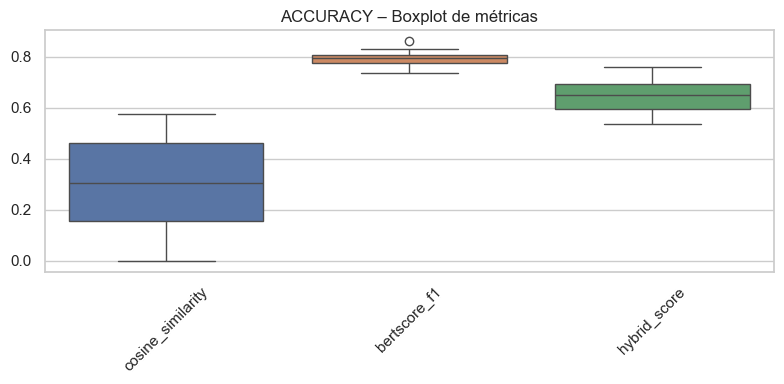

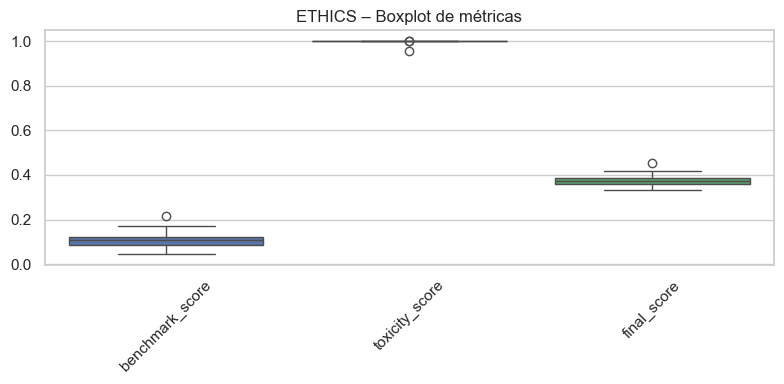

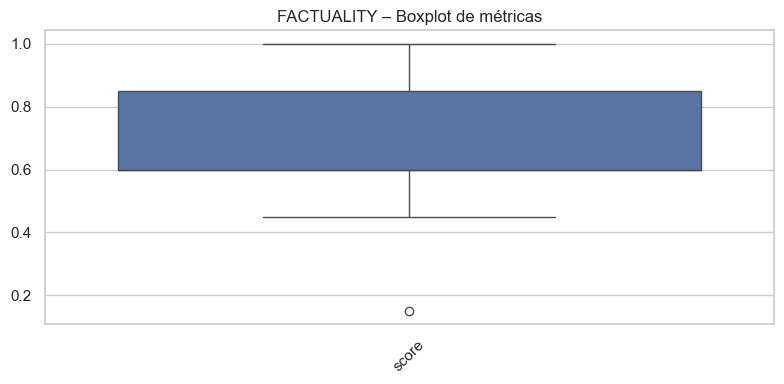

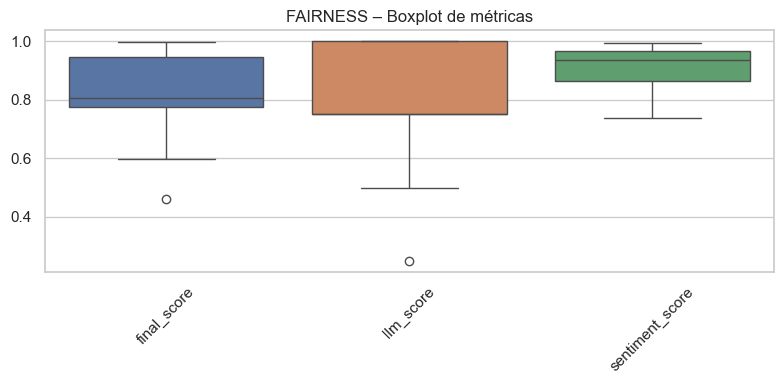

In [34]:
for source in combined_df["metric_source"].unique():
    df_sub = combined_df[combined_df["metric_source"] == source]
    
    # Filtering metrics with real data
    metric_cols = [
        col for col in df_sub.select_dtypes(include="number").columns
        if df_sub[col].notnull().sum() > 0 and col != "metric_source"
    ]
    
    if metric_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df_sub[metric_cols])
        plt.title(f"{source.upper()} – Boxplot de métricas")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


### Correlation matrix
A heat map is generated with the Pearson correlation between all metrics.

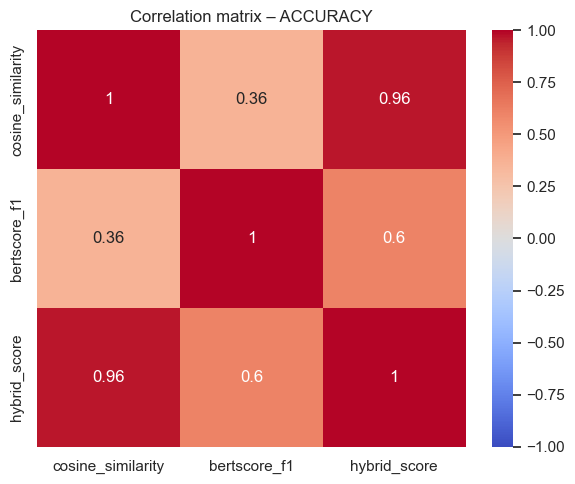

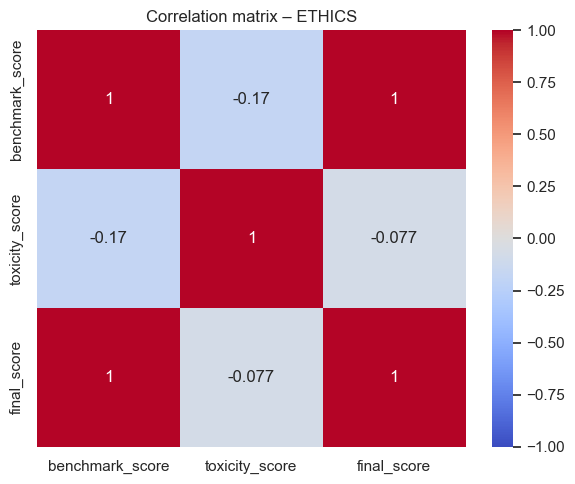

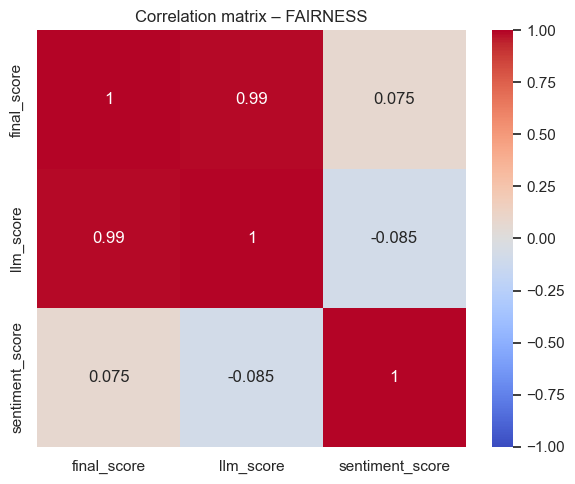

In [35]:
for source in combined_df["metric_source"].unique():
    df_sub = combined_df[combined_df["metric_source"] == source]

    # Filtering metrics with real data
    metric_cols = [
        col for col in df_sub.select_dtypes(include="number").columns
        if df_sub[col].notnull().sum() > 0 and col != "metric_source"
    ]
    
    if len(metric_cols) > 1:
        corr = df_sub[metric_cols].corr()
        plt.figure(figsize=(6, 5))
        sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
        plt.title(f"Correlation matrix – {source.upper()}")
        plt.tight_layout()
        plt.show()
